# 05__mpranalyze_compare

in this notebook, i run MPRAnalyze in 'compare' mode to get log2 foldchanges and p-values between (a) sequence orthologs and (b) cell types.

In [1]:
# install MPRAnalyze
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install("MPRAnalyze", version = "3.8")

Bioconductor version 3.8 (BiocManager 1.30.4), R 3.5.1 (2018-07-02)
Installing package(s) 'MPRAnalyze'
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Update old packages: 'assertthat', 'backports', 'BH', 'boot', 'broom', 'callr',
  'caret', 'class', 'cli', 'clipr', 'cluster', 'codetools', 'colorspace',
  'curl', 'data.table', 'dbplyr', 'ddalpha', 'digest', 'dimRed', 'dplyr',
  'evaluate', 'fansi', 'forcats', 'formatR', 'geometry', 'ggplot2', 'glmnet',
  'glue', 'gower', 'gtable', 'haven', 'hexbin', 'highr', 'htmlwidgets',
  'httpuv', 'httr', 'ipred', 'IRdisplay', 'IRkernel', 'jsonlite', 'kernlab',
  'knitr', 'later', 'lattice', 'lava', 'lazyeval', 'magic', 'markdown', 'MASS',
  'Matrix', 'mgcv', 'mime', 'ModelMetrics', 'modelr', 'nlme', 'numDeriv',
  'openssl', 'pillar', 'pkgconfig', 'pls', 'processx', 'progress', 'purrr',
  'quantmod', 'R6', 'Rcpp', 'readr', 'readxl', 'recipes', 'repr', 'reprex',
  'rlang', 'rmarkdown', 'robustbase', 'rpart', 'rstudioapi

In [2]:
# install RCurl
install.packages("RCurl")

Warning message in install.packages("RCurl"):
“installation of package ‘RCurl’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [3]:
# load the package
library(MPRAnalyze)
library(tidyr)

## 1. load data

### first load data for library depth correction

In [4]:
dna_counts_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_counts.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)

# since we only have 1 dna replicate -- add another so code doesn't crash (expects matrix)
dna_counts_depth["dna_2"] <- dna_counts_depth["dna_1"]

row.names(dna_counts_depth) <- dna_counts_depth$element
dna_counts_depth <- dna_counts_depth[ , !(names(dna_counts_depth) %in% c("element")), drop=FALSE]
dna_counts_depth <- as.matrix(dna_counts_depth)

In [5]:
rna_counts_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_counts.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
row.names(rna_counts_depth) <- rna_counts_depth$element
rna_counts_depth <- rna_counts_depth[ , !(names(rna_counts_depth) %in% c("element")), drop=FALSE]
rna_counts_depth <- as.matrix(rna_counts_depth)

In [6]:
dna_cols_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_col_ann.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
names(dna_cols_depth) <- c("id", "condition", "sample")

# add second row to dna_cols_depth
row2 <- data.frame(id="dna_2", condition="dna", sample="2")
dna_cols_depth <- rbind(dna_cols_depth, row2)
row.names(dna_cols_depth) <- dna_cols_depth$id

rna_cols_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_col_ann.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
names(rna_cols_depth) <- c("id", "condition", "sample")
row.names(rna_cols_depth) <- rna_cols_depth$id
dna_cols_depth

,id,condition,sample
dna_1,dna_1,dna,1
dna_2,dna_2,dna,2


In [7]:
# make sure everything is a factor
dna_cols_depth$sample <- as.factor(dna_cols_depth$sample)
rna_cols_depth$sample <- as.factor(rna_cols_depth$sample)
dna_cols_depth$condition <- as.factor(dna_cols_depth$condition)
rna_cols_depth$condition <- as.factor(rna_cols_depth$condition)

### then data to model: first, DNA (same for all models)

In [8]:
all_comp_dna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_counts.all_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(all_comp_dna_counts) <- all_comp_dna_counts$comp_id
all_comp_dna_counts <- all_comp_dna_counts[ , !(names(all_comp_dna_counts) %in% c("comp_id"))]
all_comp_dna_counts <- as.matrix(all_comp_dna_counts)

In [9]:
all_comp_dna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_col_ann.all_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(all_comp_dna_cols) <- all_comp_dna_cols$X

In [10]:
all_comp_dna_cols$barcode <- as.factor(all_comp_dna_cols$barcode)
all_comp_dna_cols$sample <- as.factor(all_comp_dna_cols$sample)
all_comp_dna_cols$seq <- as.factor(all_comp_dna_cols$seq)
all_comp_dna_cols$condition <- as.factor(all_comp_dna_cols$condition)

### then controls (same for all models)

In [11]:
all_comp_ctrls <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/ctrl_status.all_comp.mpranalyze.txt", sep="\t", header=TRUE)
all_comp_ctrls <- as.logical(all_comp_ctrls$ctrl_status)
head(all_comp_ctrls)

[1] FALSE FALSE FALSE FALSE FALSE FALSE

In [12]:
length(all_comp_ctrls)

[1] 3679

### then data to model: native effects

In [13]:
native_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/native_rna_counts.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(native_rna_counts) <- native_rna_counts$comp_id
native_rna_counts <- native_rna_counts[ , !(names(native_rna_counts) %in% c("comp_id"))]
native_rna_counts <- as.matrix(native_rna_counts)

In [14]:
native_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/native_col_ann.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(native_rna_cols) <- native_rna_cols$X

In [15]:
# make sure everything is a factor
native_rna_cols$barcode <- as.factor(native_rna_cols$barcode)
native_rna_cols$sample <- as.factor(native_rna_cols$sample)
native_rna_cols$seq <- as.factor(native_rna_cols$seq)
native_rna_cols$condition <- as.factor(native_rna_cols$condition)

In [16]:
head(native_rna_cols)

,X,sample,condition,barcode,seq
samp:HUES64_rep1__barc:10__seq:human,samp:HUES64_rep1__barc:10__seq:human,1,HUES64,10,human
samp:HUES64_rep1__barc:11__seq:human,samp:HUES64_rep1__barc:11__seq:human,1,HUES64,11,human
samp:HUES64_rep1__barc:12__seq:human,samp:HUES64_rep1__barc:12__seq:human,1,HUES64,12,human
samp:HUES64_rep1__barc:13__seq:human,samp:HUES64_rep1__barc:13__seq:human,1,HUES64,13,human
samp:HUES64_rep1__barc:1__seq:human,samp:HUES64_rep1__barc:1__seq:human,1,HUES64,1,human
samp:HUES64_rep1__barc:2__seq:human,samp:HUES64_rep1__barc:2__seq:human,1,HUES64,2,human


### cis+ trans interactions

In [17]:
all_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/all_rna_counts.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(all_rna_counts) <- all_rna_counts$comp_id
all_rna_counts <- all_rna_counts[ , !(names(all_rna_counts) %in% c("comp_id"))]
all_rna_counts <- as.matrix(all_rna_counts)

In [18]:
all_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/all_col_ann.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(all_rna_cols) <- all_rna_cols$X

In [19]:
# make sure everything is a factor
all_rna_cols$barcode <- as.factor(all_rna_cols$barcode)
all_rna_cols$sample <- as.factor(all_rna_cols$sample)
all_rna_cols$seq <- as.factor(all_rna_cols$seq)
all_rna_cols$condition <- as.factor(all_rna_cols$condition)

### human/mouse data for cis effects in each cell line

In [20]:
# for seq comparisons, load each cell line data separately
hues64_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/HUES64_rna_counts.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(hues64_rna_counts) <- hues64_rna_counts$comp_id
hues64_rna_counts <- hues64_rna_counts[ , !(names(hues64_rna_counts) %in% c("comp_id"))]
hues64_rna_counts <- as.matrix(hues64_rna_counts)

mesc_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mESC_rna_counts.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mesc_rna_counts) <- mesc_rna_counts$comp_id
mesc_rna_counts <- mesc_rna_counts[ , !(names(mesc_rna_counts) %in% c("comp_id"))]
mesc_rna_counts <- as.matrix(mesc_rna_counts)

In [21]:
hues64_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/HUES64_col_ann.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(hues64_rna_cols) <- hues64_rna_cols$X

mesc_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mESC_col_ann.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mesc_rna_cols) <- mesc_rna_cols$X

In [22]:
# make sure everything is a factor
hues64_rna_cols$barcode <- as.factor(hues64_rna_cols$barcode)
mesc_rna_cols$barcode <- as.factor(mesc_rna_cols$barcode)

hues64_rna_cols$sample <- as.factor(hues64_rna_cols$sample)
mesc_rna_cols$sample <- as.factor(mesc_rna_cols$sample)

hues64_rna_cols$seq <- as.factor(hues64_rna_cols$seq)
mesc_rna_cols$seq <- as.factor(mesc_rna_cols$seq)

hues64_rna_cols$condition <- as.factor(hues64_rna_cols$condition)
mesc_rna_cols$condition <- as.factor(mesc_rna_cols$condition)

### human/mouse data for trans effects of each sequence

In [23]:
# for cell comparisons, load each cell line data separately
human_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/human_rna_counts.cell_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(human_rna_counts) <- human_rna_counts$comp_id
human_rna_counts <- human_rna_counts[ , !(names(human_rna_counts) %in% c("comp_id"))]
human_rna_counts <- as.matrix(human_rna_counts)

mouse_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mouse_rna_counts.cell_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mouse_rna_counts) <- mouse_rna_counts$comp_id
mouse_rna_counts <- mouse_rna_counts[ , !(names(mouse_rna_counts) %in% c("comp_id"))]
mouse_rna_counts <- as.matrix(mouse_rna_counts)

In [24]:
human_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/human_col_ann.cell_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(human_rna_cols) <- human_rna_cols$X

mouse_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mouse_col_ann.cell_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mouse_rna_cols) <- mouse_rna_cols$X

In [25]:
# make sure everything is a factor
human_rna_cols$barcode <- as.factor(human_rna_cols$barcode)
mouse_rna_cols$barcode <- as.factor(mouse_rna_cols$barcode)

human_rna_cols$sample <- as.factor(human_rna_cols$sample)
mouse_rna_cols$sample <- as.factor(mouse_rna_cols$sample)

human_rna_cols$seq <- as.factor(human_rna_cols$seq)
mouse_rna_cols$seq <- as.factor(mouse_rna_cols$seq)

human_rna_cols$condition <- as.factor(human_rna_cols$condition)
mouse_rna_cols$condition <- as.factor(mouse_rna_cols$condition)

## 2. estimate library depth for sample/condition pair

since our library has many more sequences than just the TSSs we want to model, estimate the library depth based on the full seq output (or downsampled counts, in HUES64 case), then manually provide this estimation to the model

In [26]:
# create MPRA object
depth_obj <- MpraObject(dnaCounts = dna_counts_depth, rnaCounts = rna_counts_depth, 
                        dnaAnnot = dna_cols_depth, rnaAnnot = rna_cols_depth)

In [27]:
# estimate depth factors using uq -- here, a sample/condition pair == 1 library
depth_obj <- estimateDepthFactors(depth_obj, lib.factor = c("sample", "condition"),  depth.estimator='uq',
                                  which.lib = "both")

In [28]:
rna_depths <- rnaDepth(depth_obj)
rna_depths

[1] 1.0000000 0.9526851 1.0227141

In [29]:
rna_cols_depth

,id,condition,sample
HUES64_rep1,HUES64_rep1,HUES64,1
HUES64_rep2,HUES64_rep2,HUES64,2
mESC_rep1,mESC_rep1,mESC,1


## 3. run model to compare native effects

In [30]:
# first need to set the dnadepths and rnadepths manually
all_comp_dna_cols$depth <- rep(1, nrow(all_comp_dna_cols))

# note 13 will change depending how many barcodes there are per element
native_rna_cols$depth <- c(rep(rna_depths[1], 13), rep(rna_depths[2], 13), rep(rna_depths[3], 13))

In [31]:
# create MPRA object
obj <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = native_rna_counts, 
                  dnaAnnot = all_comp_dna_cols, rnaAnnot = native_rna_cols, controls = all_comp_ctrls)

In [32]:
obj <- setDepthFactors(obj, dnaDepth = all_comp_dna_cols$depth, rnaDepth = native_rna_cols$depth)

In [33]:
obj <- analyzeComparative(obj = obj, 
                          dnaDesign = ~ barcode, 
                          rnaDesign = ~ seq, 
                          reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-46145311.4553979
iter:3	log-likelihood:-46145557.4489102
Fitting model...
[===========================================================] 100% (3679/3679)
Fitting reduced model...
Analysis Done!                                                                


In [34]:
native_res <- testLrt(obj)
head(native_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
h.2__div_lnc__m.1__div_lnc,0.5392045,4.627626e-01,0.5901225504,1,14,5,4,-0.2762889
h.3__div_lnc__m.2__antisense,17.1447050,3.463736e-05,0.0002671507,1,13,5,4,2.1956463
h.4__antisense_upep__m.3__protein_coding,2.8309741,9.246226e-02,0.1715424366,1,14,5,4,-0.4941195
h.5__intergenic__m.4__intergenic_upep,5.1580876,2.313836e-02,0.0576734652,1,14,5,4,0.5938779
h.6__intergenic__m.4__intergenic_upep,4.7952271,2.853869e-02,0.0687132554,1,14,5,4,-0.5637790
h.7__div_lnc__m.5__div_lnc,0.1609846,6.882516e-01,0.7797343993,1,14,5,4,0.1100849


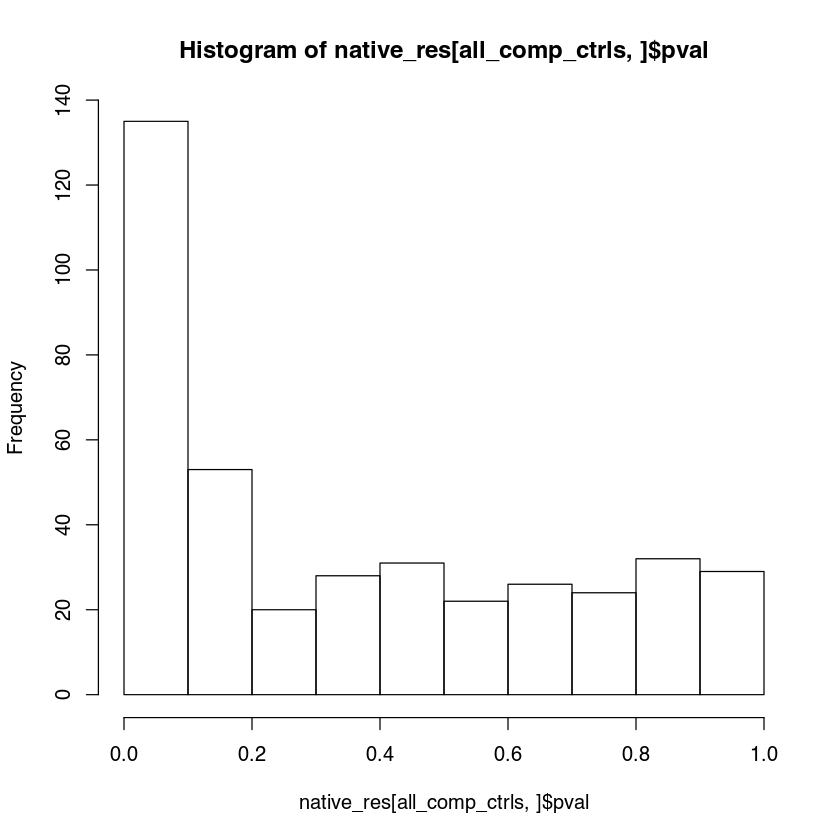

In [36]:
hist(native_res[all_comp_ctrls,]$pval)

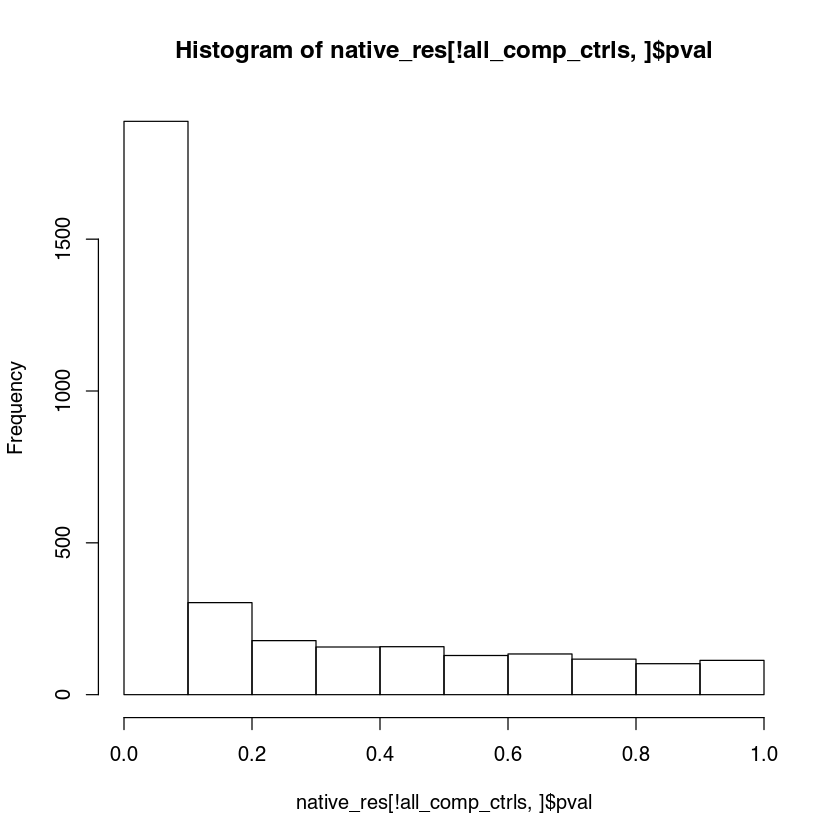

In [37]:
hist(native_res[!all_comp_ctrls,]$pval)

## 4. run model to compare seq / condition interactions

In [38]:
# note 13 will change depending how many barcodes there are per element
all_rna_cols$depth <- c(rep(rna_depths[1], 13*2), rep(rna_depths[2], 13*2), rep(rna_depths[3], 13*2))

In [39]:
# create MPRA object
obj1 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = all_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = all_rna_cols, controls = all_comp_ctrls)

In [40]:
obj1 <- setDepthFactors(obj1, dnaDepth = all_comp_dna_cols$depth, rnaDepth = all_rna_cols$depth)

In [41]:
head(all_rna_cols)

,X,sample,condition,barcode,seq,depth
samp:HUES64_rep1__barc:10__seq:human,samp:HUES64_rep1__barc:10__seq:human,1,HUES64,10,human,1
samp:HUES64_rep1__barc:10__seq:mouse,samp:HUES64_rep1__barc:10__seq:mouse,1,HUES64,10,mouse,1
samp:HUES64_rep1__barc:11__seq:human,samp:HUES64_rep1__barc:11__seq:human,1,HUES64,11,human,1
samp:HUES64_rep1__barc:11__seq:mouse,samp:HUES64_rep1__barc:11__seq:mouse,1,HUES64,11,mouse,1
samp:HUES64_rep1__barc:12__seq:human,samp:HUES64_rep1__barc:12__seq:human,1,HUES64,12,human,1
samp:HUES64_rep1__barc:12__seq:mouse,samp:HUES64_rep1__barc:12__seq:mouse,1,HUES64,12,mouse,1


In [42]:
obj1 <- analyzeComparative(obj = obj1, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ seq + condition + seq:condition, 
                           reducedDesign = ~ seq + condition) 

Fitting controls-based background model...
iter:2	log-likelihood:-92170084.5927101
iter:3	log-likelihood:-92162908.2231506
iter:4	log-likelihood:-92159714.4934419
iter:5	log-likelihood:-92157172.4645559
iter:6	log-likelihood:-92155078.4186964
iter:7	log-likelihood:-92153355.4944124
iter:8	log-likelihood:-92151942.9672853
iter:9	log-likelihood:-92150767.9218067
iter:10	log-likelihood:-92149797.2358446
iter:11	log-likelihood:-92148994.2404186
iter:12	log-likelihood:-92148320.1584312
iter:13	log-likelihood:-92147767.4945272
iter:14	log-likelihood:-92147320.1657721
iter:15	log-likelihood:-92146941.6601187
iter:16	log-likelihood:-92146619.7564975
iter:17	log-likelihood:-92146370.601993
iter:18	log-likelihood:-92146160.6609291
iter:19	log-likelihood:-92145978.9075199
iter:20	log-likelihood:-92145830.2948812
iter:21	log-likelihood:-92145708.0632897
iter:22	log-likelihood:-92145602.2996124
iter:23	log-likelihood:-92145520.8850172
Fitting model...
[==============================================

In [43]:
int_res <- testLrt(obj1)
head(int_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
h.2__div_lnc__m.1__div_lnc,0.14304310,0.7052743,0.9987798,1,14,9,8,-0.18277286
h.3__div_lnc__m.2__antisense,2.04974622,0.1522316,0.8444489,1,13,9,8,-1.07074100
h.4__antisense_upep__m.3__protein_coding,2.35766466,0.1246687,0.7948980,1,14,9,8,-0.59646378
h.5__intergenic__m.4__intergenic_upep,0.34438253,0.5573104,0.9981239,1,14,9,8,0.20434635
h.6__intergenic__m.4__intergenic_upep,0.47605336,0.4902154,0.9859163,1,14,9,8,0.23247928
h.7__div_lnc__m.5__div_lnc,0.08239098,0.7740830,0.9987798,1,14,9,8,0.09711843


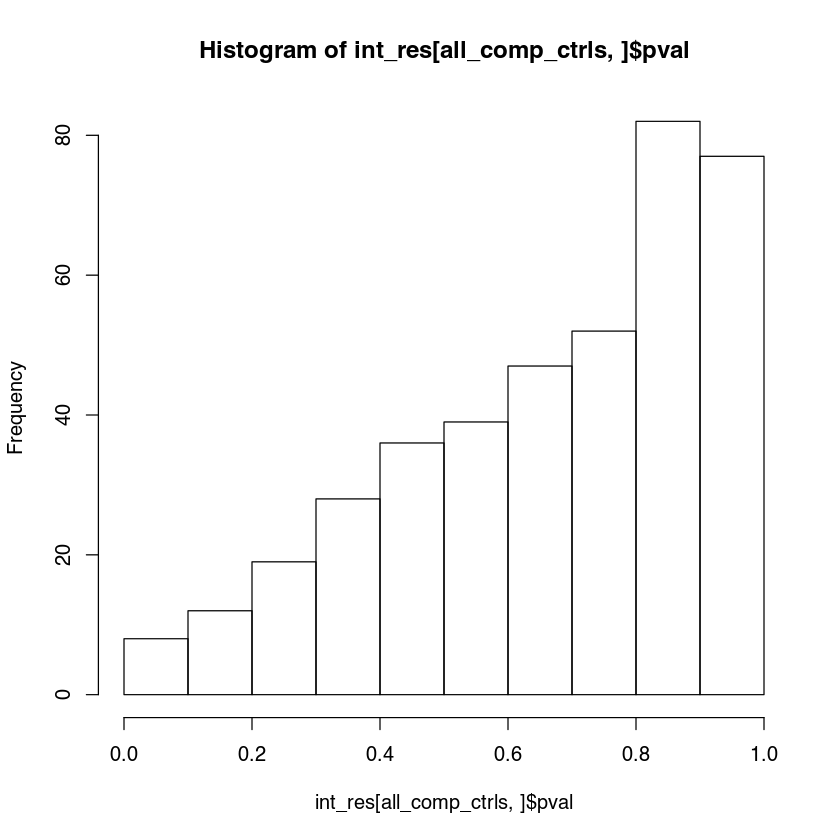

In [45]:
hist(int_res[all_comp_ctrls,]$pval)

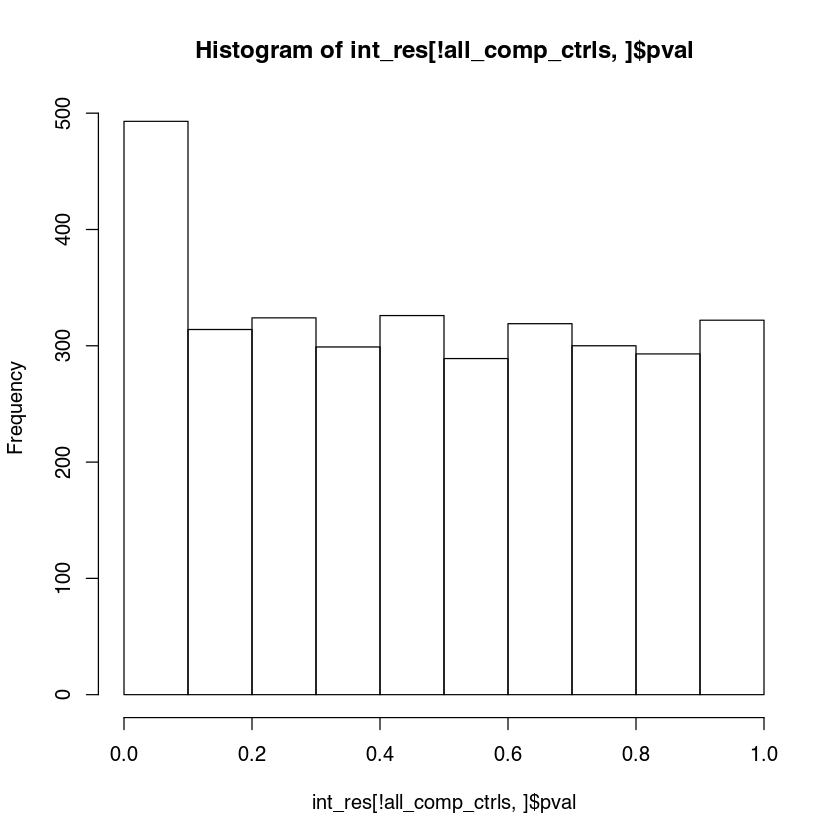

In [44]:
hist(int_res[!all_comp_ctrls,]$pval)

## 5. run model to compare seqs in HUES64

In [46]:
# note 13 will change depending how many barcodes there are per element
hues64_rna_cols$depth <- c(rep(rna_depths[1], 13*2), rep(rna_depths[2], 13*2))

In [47]:
# create MPRA object
obj2 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = hues64_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = hues64_rna_cols, controls = all_comp_ctrls)

In [48]:
obj2 <- setDepthFactors(obj2, dnaDepth = all_comp_dna_cols$depth, rnaDepth = hues64_rna_cols$depth)

In [49]:
obj2 <- analyzeComparative(obj = obj2, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ seq, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-61625867.9944322
iter:3	log-likelihood:-61631614.9919815
Fitting model...
[===========================================================] 100% (3679/3679)
Fitting reduced model...
Analysis Done!                                                                


In [50]:
hues64_res <- testLrt(obj2)
head(hues64_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
h.2__div_lnc__m.1__div_lnc,0.09110531,7.627767e-01,8.307446e-01,1,14,5,4,-0.09510684
h.3__div_lnc__m.2__antisense,12.07978873,5.097137e-04,1.792769e-03,1,13,5,4,1.62212149
h.4__antisense_upep__m.3__protein_coding,2.03224594,1.539929e-01,2.371464e-01,1,14,5,4,-0.34149643
h.5__intergenic__m.4__intergenic_upep,0.32922721,5.661145e-01,6.686958e-01,1,14,5,4,0.12911120
h.6__intergenic__m.4__intergenic_upep,19.72321833,8.950725e-06,5.210399e-05,1,14,5,4,-1.03153530
h.7__div_lnc__m.5__div_lnc,0.52784874,4.675127e-01,5.797031e-01,1,14,5,4,-0.16648585


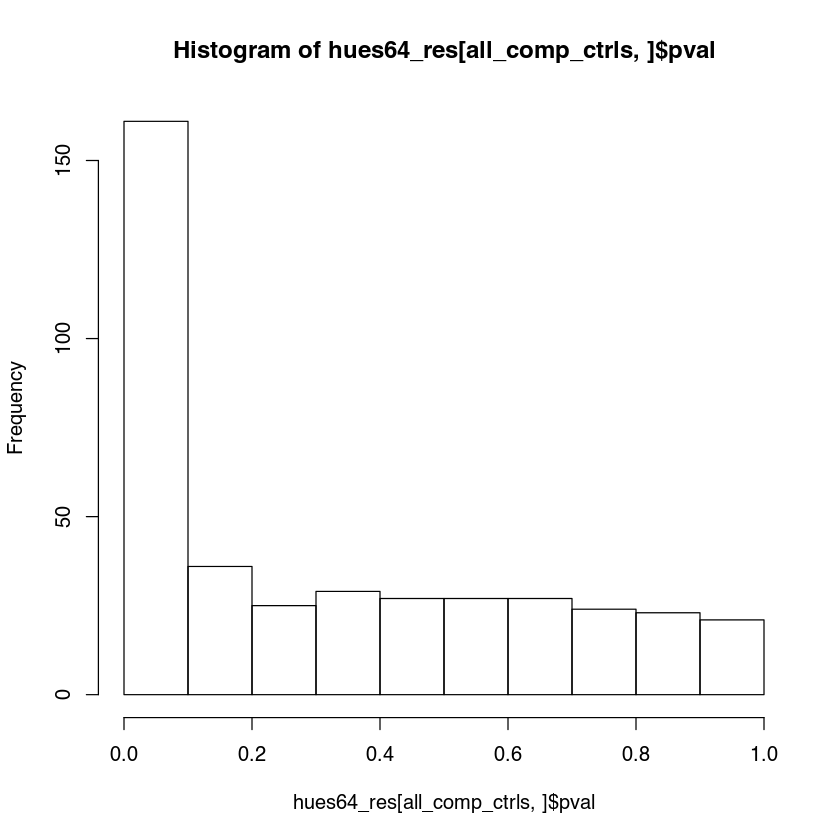

In [51]:
hist(hues64_res[all_comp_ctrls,]$pval)

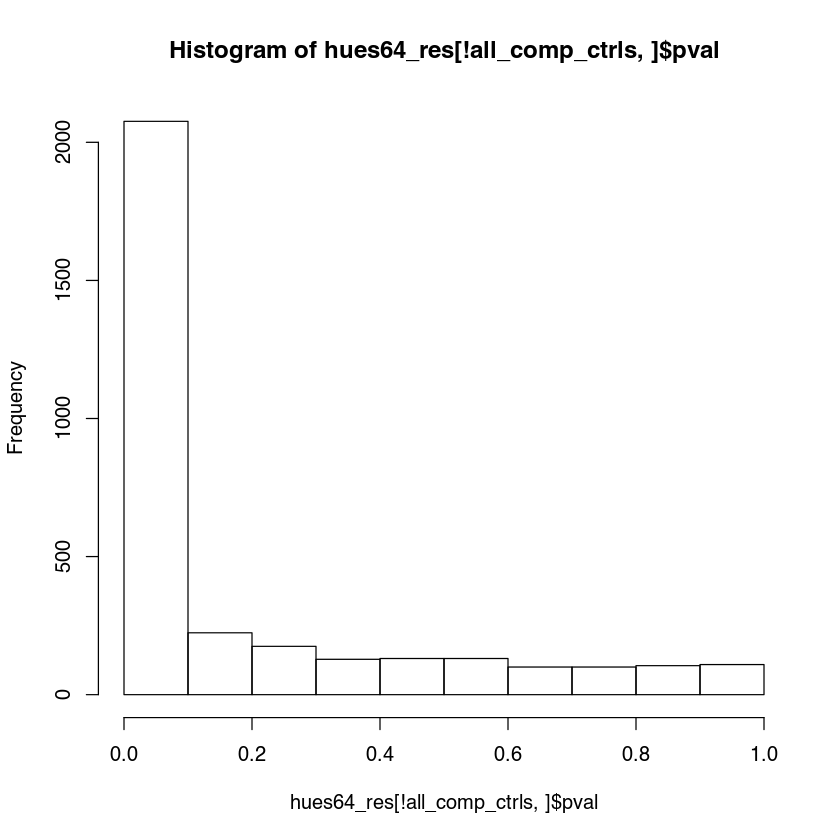

In [52]:
hist(hues64_res[!all_comp_ctrls,]$pval)

## 6. run model to compare seqs in mESC

In [53]:
# note 13 will change depending how many barcodes there are per element
mesc_rna_cols$depth <- c(rep(rna_depths[3], 13*2))

In [54]:
# create MPRA object
obj3 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = mesc_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = mesc_rna_cols, controls = all_comp_ctrls)

In [55]:
obj3 <- setDepthFactors(obj3, dnaDepth = all_comp_dna_cols$depth, rnaDepth = mesc_rna_cols$depth)

In [56]:
obj3 <- analyzeComparative(obj = obj3, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ seq, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-30989177.5575887
iter:3	log-likelihood:-30987397.4311343
iter:4	log-likelihood:-30986132.7466446
iter:5	log-likelihood:-30985227.4850461
iter:6	log-likelihood:-30984566.7505815
iter:7	log-likelihood:-30984105.3236077
iter:8	log-likelihood:-30983737.3865414
iter:9	log-likelihood:-30983493.6352709
iter:10	log-likelihood:-30983317.959452
iter:11	log-likelihood:-30983180.0877457
iter:12	log-likelihood:-30983081.0451824
iter:13	log-likelihood:-30983006.9787277
iter:14	log-likelihood:-30982948.9320417
iter:15	log-likelihood:-30982887.2720064
iter:16	log-likelihood:-30982848.8255175
iter:17	log-likelihood:-30982825.5836163
Fitting model...
[===========================================================] 100% (3679/3679)
Fitting reduced model...
Analysis Done!                                                                


In [57]:
mesc_res <- testLrt(obj3)
head(mesc_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
h.2__div_lnc__m.1__div_lnc,0.214028923,0.64362774,0.77712716,1,14,5,4,-0.20027383
h.3__div_lnc__m.2__antisense,0.886815015,0.34634187,0.51565833,1,13,5,4,0.72519222
h.4__antisense_upep__m.3__protein_coding,5.341382157,0.02082496,0.07236010,1,14,5,4,-0.84308304
h.5__intergenic__m.4__intergenic_upep,0.754079861,0.38518759,0.55757731,1,14,5,4,0.26144961
h.6__intergenic__m.4__intergenic_upep,4.678431755,0.03054362,0.09490708,1,14,5,4,-0.68959163
h.7__div_lnc__m.5__div_lnc,0.003289965,0.95425985,0.97438856,1,14,5,4,0.01808852


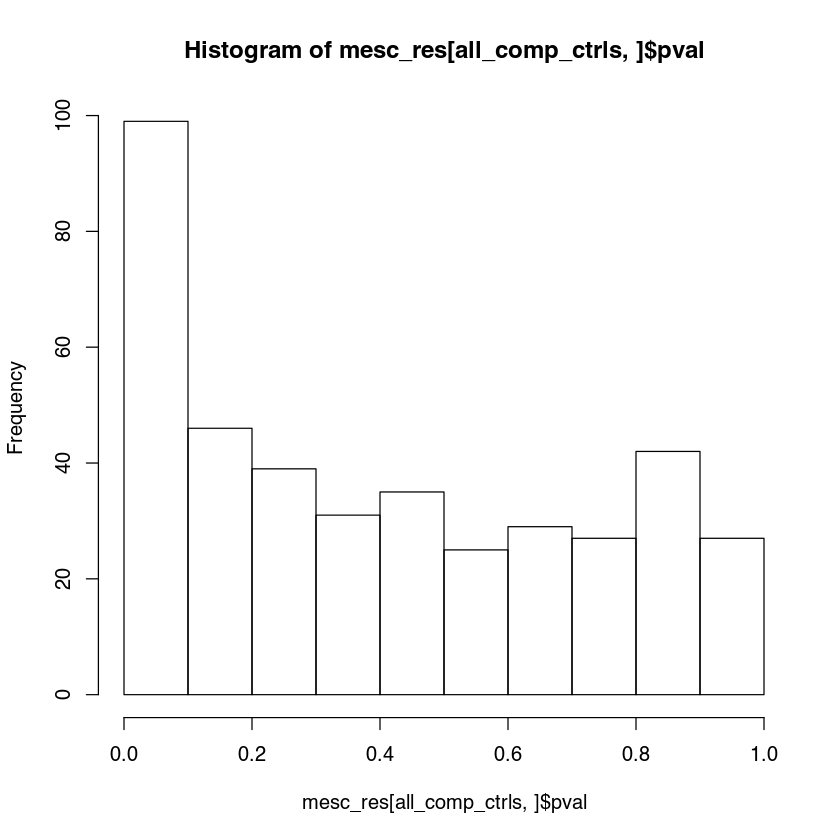

In [58]:
hist(mesc_res[all_comp_ctrls,]$pval)

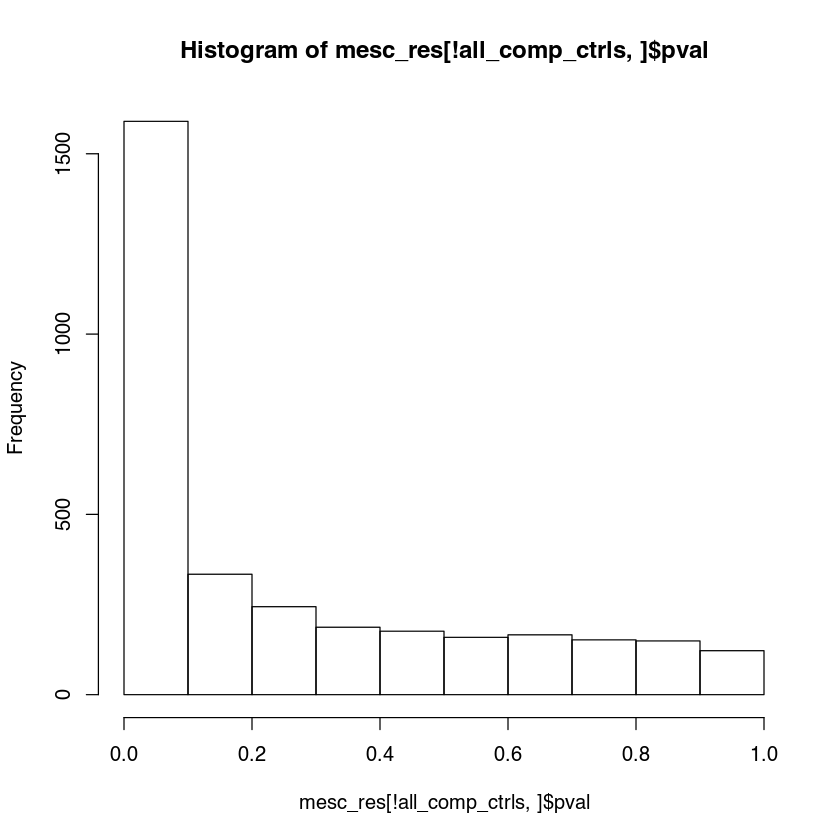

In [59]:
hist(mesc_res[!all_comp_ctrls,]$pval)

## 7. run model to compare cells for human seq

In [60]:
# note 13 will change depending how many barcodes there are per element
human_rna_cols$depth <- c(rep(rna_depths[1], 13), rep(rna_depths[2], 13), rep(rna_depths[3], 13))

In [61]:
# create MPRA object
obj4 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = human_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = human_rna_cols, controls = all_comp_ctrls)

In [62]:
obj4 <- setDepthFactors(obj4, dnaDepth = all_comp_dna_cols$depth, rnaDepth = human_rna_cols$depth)

In [63]:
obj4 <- analyzeComparative(obj = obj4, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ condition, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-44301564.5199541
iter:3	log-likelihood:-44260701.4517511
iter:4	log-likelihood:-44235940.6047704
iter:5	log-likelihood:-44217786.4203739
iter:6	log-likelihood:-44204273.0788627
iter:7	log-likelihood:-44194129.43207
iter:8	log-likelihood:-44186440.7624305
iter:9	log-likelihood:-44180597.0470354
iter:10	log-likelihood:-44176109.7720894
iter:11	log-likelihood:-44172665.4462322
iter:12	log-likelihood:-44170027.8780422
iter:13	log-likelihood:-44167987.0323412
iter:14	log-likelihood:-44166419.8310676
iter:15	log-likelihood:-44165207.4539735
iter:16	log-likelihood:-44164245.2599562
iter:17	log-likelihood:-44163529.0304577
iter:18	log-likelihood:-44162949.6751835
iter:19	log-likelihood:-44162510.5025298
iter:20	log-likelihood:-44162159.2106885
iter:21	log-likelihood:-44161880.3554179
iter:22	log-likelihood:-44161675.2175598
iter:23	log-likelihood:-44161524.6330184
iter:24	log-likelihood:-44161391.6868336
iter:25	log-likelihood:-

In [64]:
human_trans_res <- testLrt(obj4)
head(human_trans_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
h.2__div_lnc__m.1__div_lnc,0.4045306,0.52475868,0.8555111,1,14,5,4,-0.2173339
h.3__div_lnc__m.2__antisense,4.1430825,0.04180498,0.3536459,1,13,5,4,1.3000859
h.4__antisense_upep__m.3__protein_coding,3.0864956,0.07894466,0.4700069,1,14,5,4,0.4433665
h.5__intergenic__m.4__intergenic_upep,2.8655214,0.09049638,0.4925091,1,14,5,4,0.3126041
h.6__intergenic__m.4__intergenic_upep,1.3258316,0.24954814,0.6680255,1,14,5,4,0.2006312
h.7__div_lnc__m.5__div_lnc,1.6034714,0.20541196,0.6172471,1,14,5,4,0.2037850


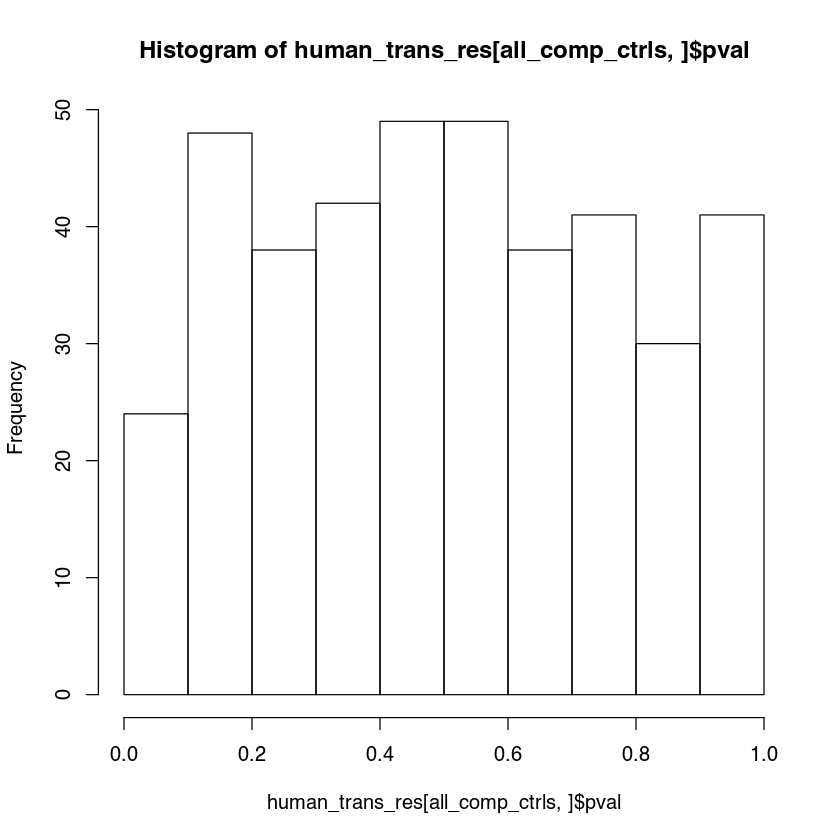

In [65]:
hist(human_trans_res[all_comp_ctrls,]$pval)

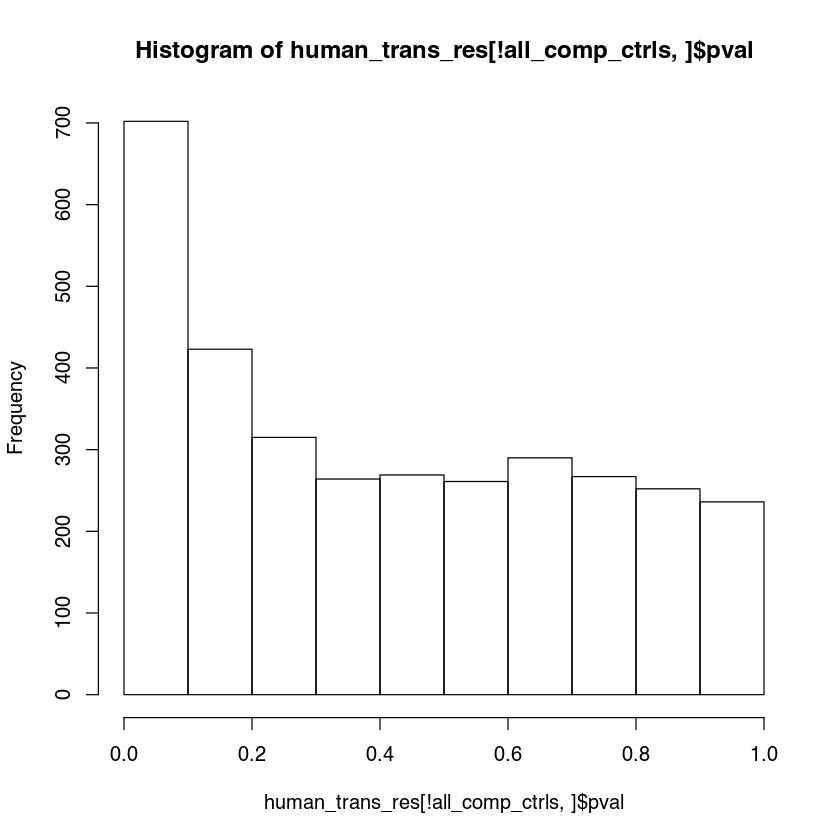

In [66]:
hist(human_trans_res[!all_comp_ctrls,]$pval)

## 8. run model to compare cells for mouse seq

In [67]:
# note 13 will change depending how many barcodes there are per element
mouse_rna_cols$depth <- c(rep(rna_depths[1], 13), rep(rna_depths[2], 13), rep(rna_depths[3], 13))

In [68]:
# create MPRA object
obj5 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = mouse_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = mouse_rna_cols, controls = all_comp_ctrls)

In [69]:
obj5 <- setDepthFactors(obj5, dnaDepth = all_comp_dna_cols$depth, rnaDepth = mouse_rna_cols$depth)

In [70]:
obj5 <- analyzeComparative(obj = obj5, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ condition, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-44484552.2482215
iter:3	log-likelihood:-44458566.9668512
iter:4	log-likelihood:-44442503.8533297
iter:5	log-likelihood:-44430391.997066
iter:6	log-likelihood:-44421157.3214644
iter:7	log-likelihood:-44414038.5150919
iter:8	log-likelihood:-44408566.4694207
iter:9	log-likelihood:-44404324.2961454
iter:10	log-likelihood:-44401011.1835181
iter:11	log-likelihood:-44398422.7300396
iter:12	log-likelihood:-44396427.4122758
iter:13	log-likelihood:-44394839.1664952
iter:14	log-likelihood:-44393591.4447443
iter:15	log-likelihood:-44392624.6110047
iter:16	log-likelihood:-44391864.4028906
iter:17	log-likelihood:-44391277.8486995
iter:18	log-likelihood:-44390810.0412108
iter:19	log-likelihood:-44390425.5747995
iter:20	log-likelihood:-44390155.0357673
iter:21	log-likelihood:-44389923.747754
iter:22	log-likelihood:-44389758.9804601
iter:23	log-likelihood:-44389613.4713472
iter:24	log-likelihood:-44389490.7240594
iter:25	log-likelihood:-

In [71]:
mouse_trans_res <- testLrt(obj5)
head(mouse_trans_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
h.2__div_lnc__m.1__div_lnc,1.6561972,0.19811755,0.5859184,1,14,5,4,-0.38455910
h.3__div_lnc__m.2__antisense,2.3045258,0.12899765,0.4921022,1,13,5,4,0.50022678
h.4__antisense_upep__m.3__protein_coding,0.1309040,0.71749661,0.9023934,1,14,5,4,-0.08848491
h.5__intergenic__m.4__intergenic_upep,4.0839903,0.04329131,0.3110510,1,14,5,4,0.46058859
h.6__intergenic__m.4__intergenic_upep,3.3455291,0.06738781,0.3759338,1,14,5,4,0.44738711
h.7__div_lnc__m.5__div_lnc,0.8236296,0.36412109,0.7269964,1,14,5,4,0.26827661


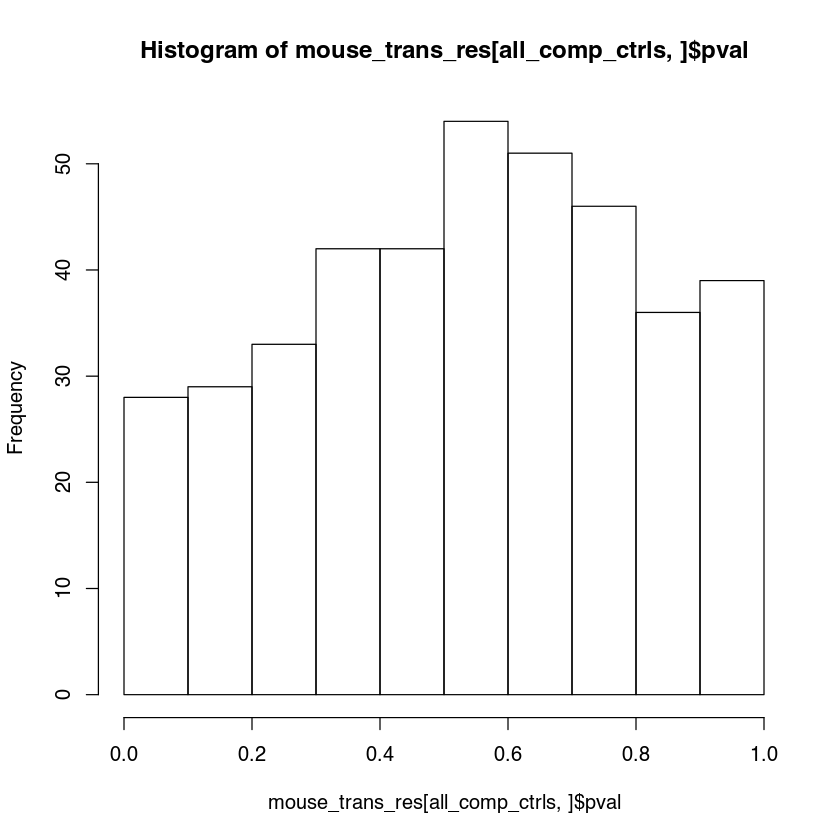

In [72]:
hist(mouse_trans_res[all_comp_ctrls,]$pval)

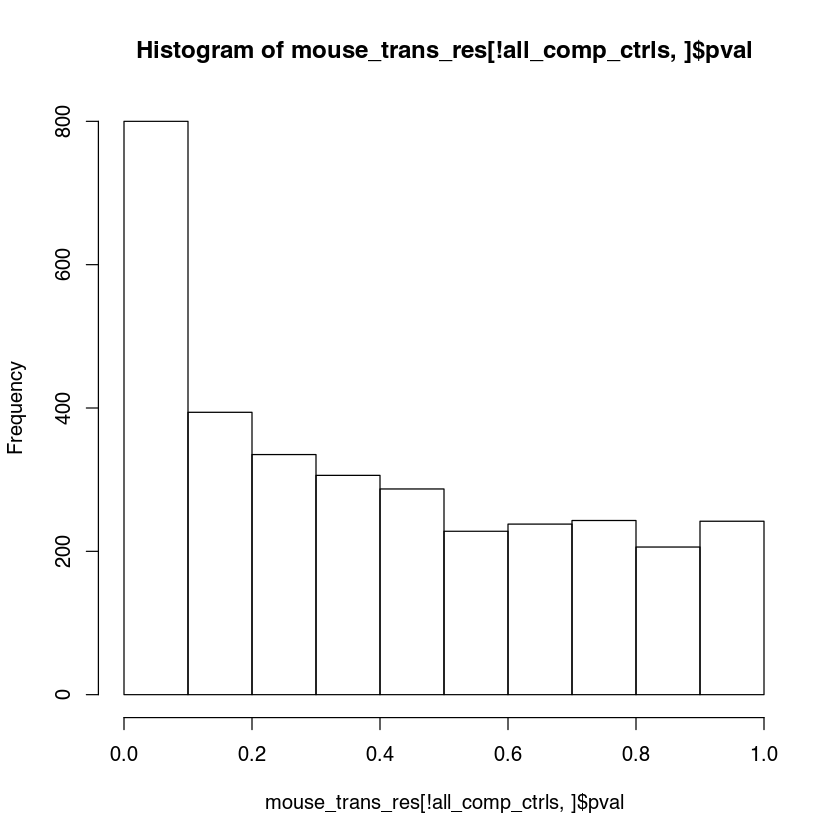

In [73]:
hist(mouse_trans_res[!all_comp_ctrls,]$pval)

## 8. write all files

In [74]:
write.table(native_res, file = "../../../data/02__mpra/02__activs/native_results.txt", sep = "\t",
            quote = FALSE)

In [75]:
write.table(int_res, file = "../../../data/02__mpra/02__activs/cis_trans_interaction_results.txt", sep = "\t",
            quote = FALSE)

In [76]:
write.table(hues64_res, file = "../../../data/02__mpra/02__activs/HUES64_cis_results.txt", sep = "\t",
            quote = FALSE)

In [77]:
write.table(mesc_res, file = "../../../data/02__mpra/02__activs/mESC_cis_results.txt", sep = "\t",
            quote = FALSE)

In [78]:
write.table(human_trans_res, file = "../../../data/02__mpra/02__activs/human_trans_results.txt", sep = "\t",
            quote = FALSE)

In [79]:
write.table(mouse_trans_res, file = "../../../data/02__mpra/02__activs/mouse_trans_results.txt", sep = "\t",
            quote = FALSE)